In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

import timeit

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

In [530]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 6587, 3578, 745, 430
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)


In [531]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

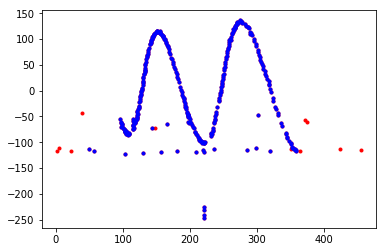

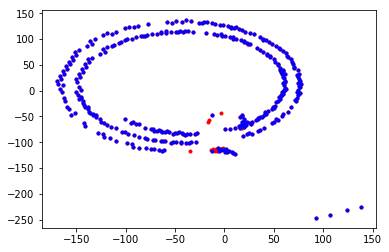

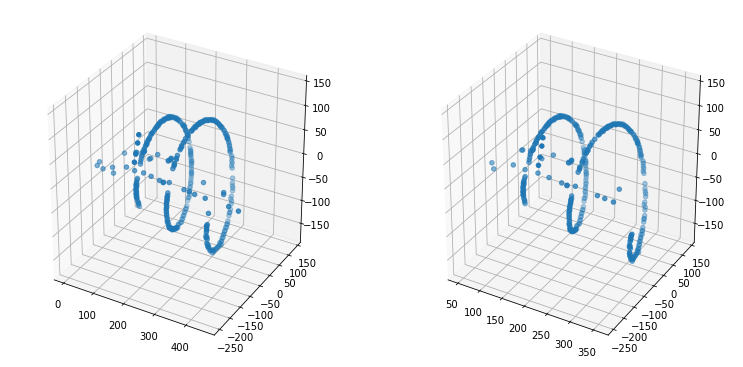

In [532]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

<IPython.core.display.Javascript object>


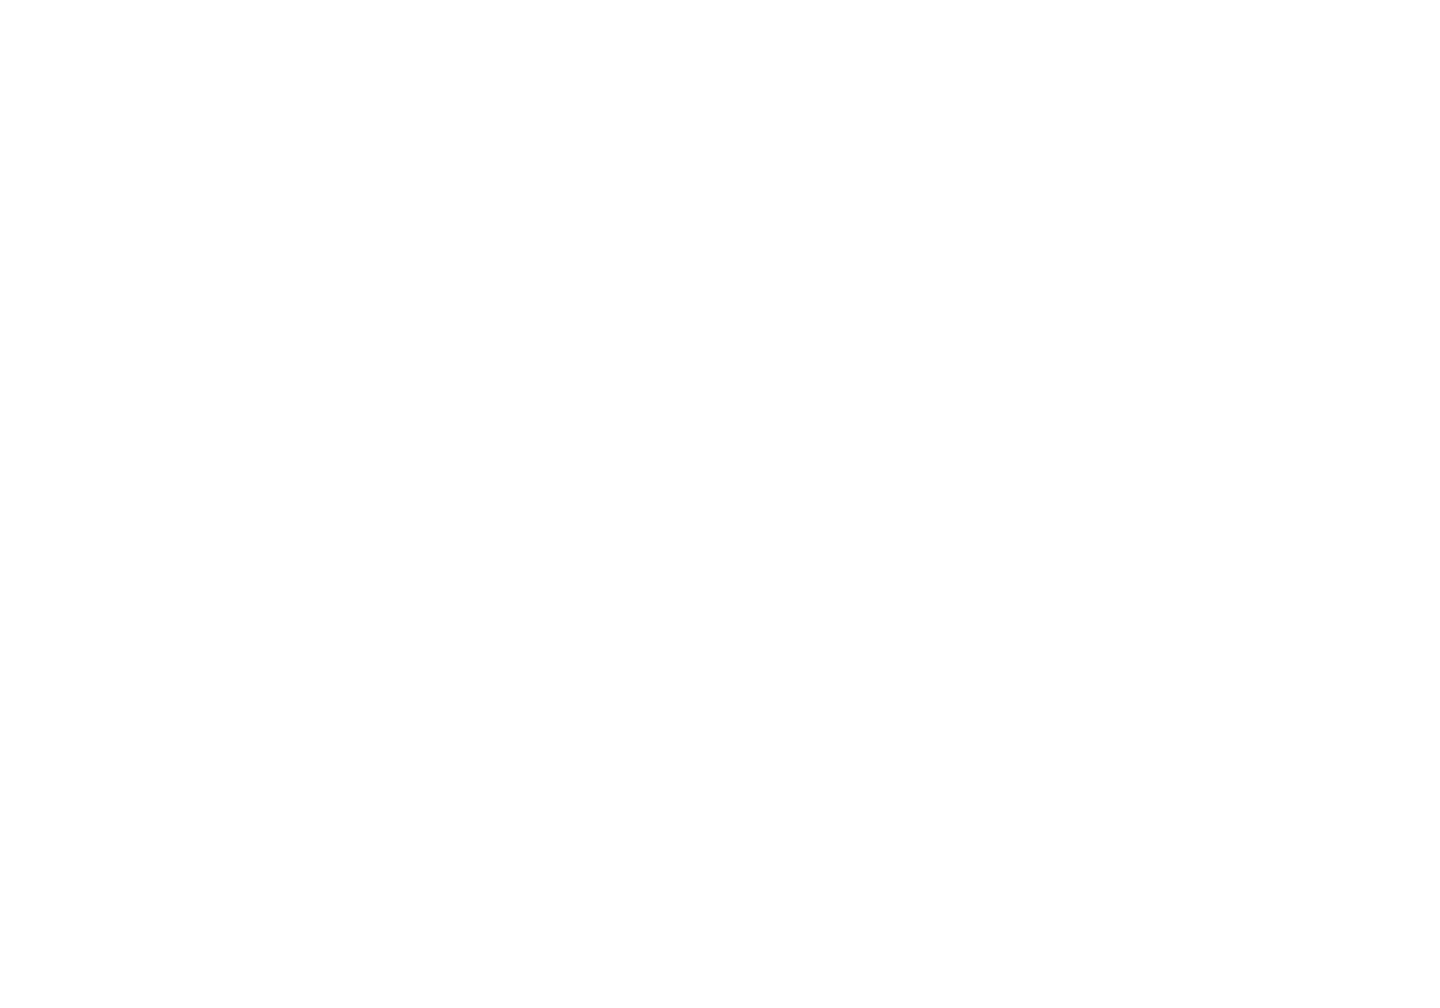

<IPython.core.display.Javascript object>


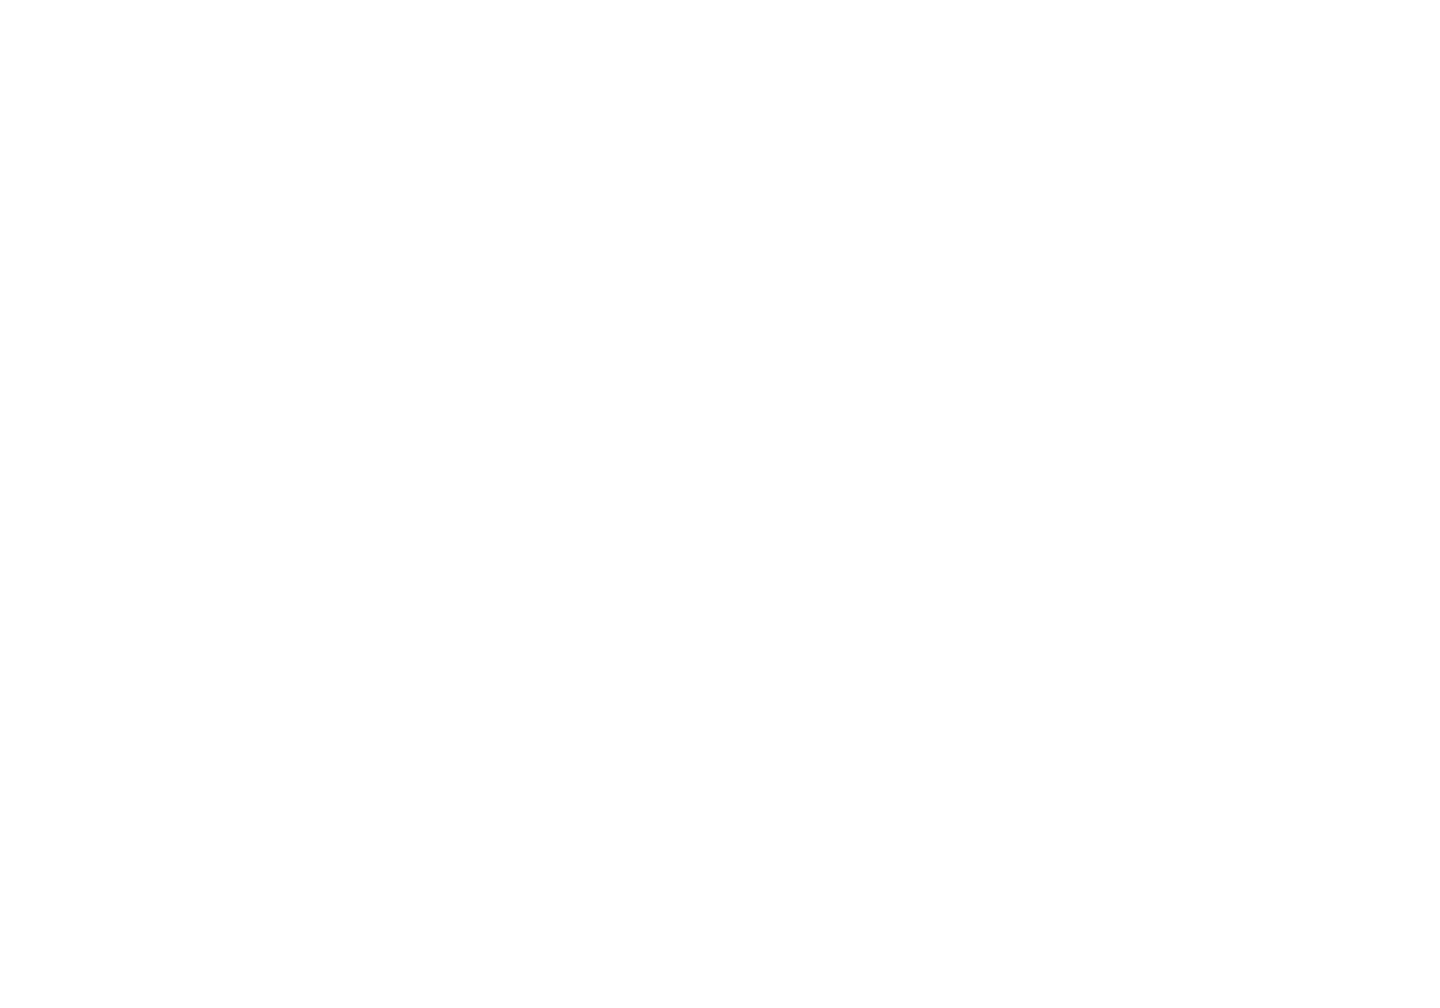

In [533]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0], c='r', label='original data')
ax.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0], c='b', label='after cut')


In [534]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values

In [535]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [536]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [537]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

Conjugate Gradient

In [538]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)


In [539]:
def cut_f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def cut_jacobian(x):
    return scipy.optimize.approx_fprime(x,cut_f,eps)

In [540]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1   
     

In [541]:
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':eps})    
cg = results.x
print(results)

   1-0.004481 0.003987 0.719717 2.094852-2.786115 1.901949 94.920084
   2-0.005245 0.012375 0.722012 2.099174-2.784263 1.926518 92.503036
   3 0.004036 0.012089 0.723674 2.104588-2.782979 1.955943 88.311230
   4 0.018230 0.010433 0.736155 2.111286-2.782995 1.989506 78.321157
   5 0.019652 0.009890 0.737568 2.112231-2.782991 1.994261 77.298672
   6 0.013989 0.005361 0.737190 2.113924-2.782836 2.002570 73.129855
   7 0.006599 0.003052 0.742142 2.114935-2.783027 2.005512 69.808445
   8 0.003758 0.003966 0.742155 2.115896-2.783456 2.008464 69.694433
   9 0.002281 0.006920 0.744206 2.117325-2.784555 2.011562 68.522606
  10 0.005438 0.008241 0.745338 2.119018-2.786145 2.014816 67.344601
  11 0.005778 0.007902 0.746429 2.119698-2.786816 2.015381 67.172814
  12 0.005323 0.006466 0.747109 2.121286-2.788157 2.016976 66.773069
     fun: 66.77306859728505
     jac: array([ 58.33328247, -45.30129147, -18.61051941, -42.26961327,
        39.58021355,  32.24349785])
 message: 'Desired error not necess

In [542]:
j = 1    
def cut_callbackF(x):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    j += 1  

In [543]:
cut_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="CG", jac=cut_jacobian, callback=cut_callbackF, options={'gtol': 30.0, 'eps':1e-13})    
cut_cg = cut_results.x
print(cut_results)

   1-0.004610 0.003824 0.720435 2.085631-2.786146 1.899839 95.079053
     fun: 95.07905301270765
     jac: array([ -82.0187521 ,   64.89667988,  170.69990253,  -14.59882545,
        -12.16933823, -113.83406448])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 77
     nit: 1
    njev: 68
  status: 2
 success: False
       x: array([-0.00460966,  0.00382372,  0.72043528,  2.08563146, -2.78614559,
        1.89983946])


In [490]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [286]:
cut_evtClean, cut_ctr = sim.make_event(cut_cg[0], cut_cg[1], cut_cg[2], cut_cg[3], cut_cg[4], cut_cg[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values


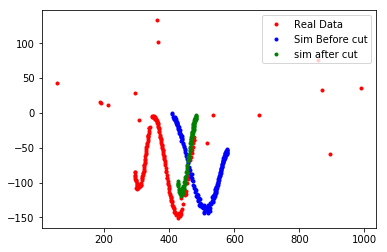

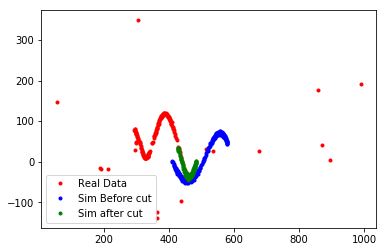

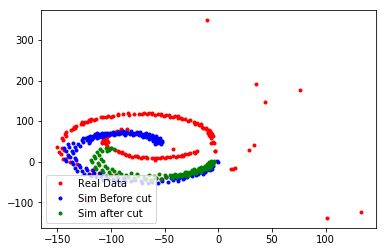

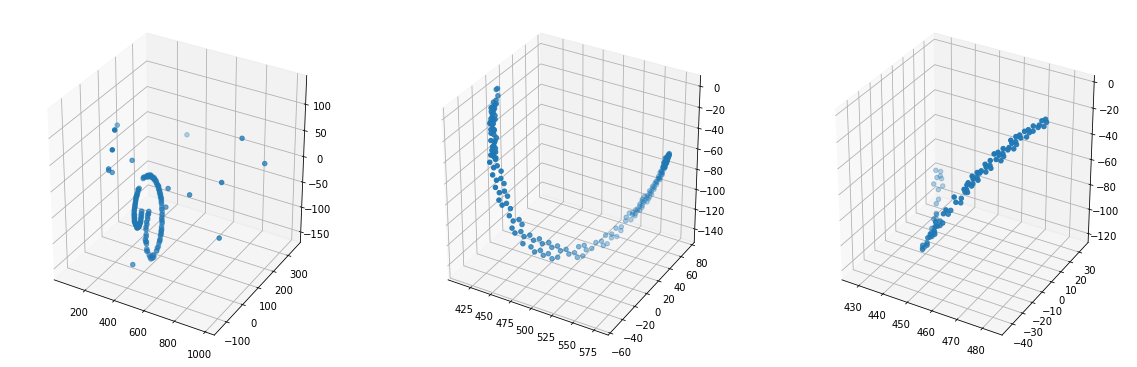

In [287]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

<IPython.core.display.Javascript object>


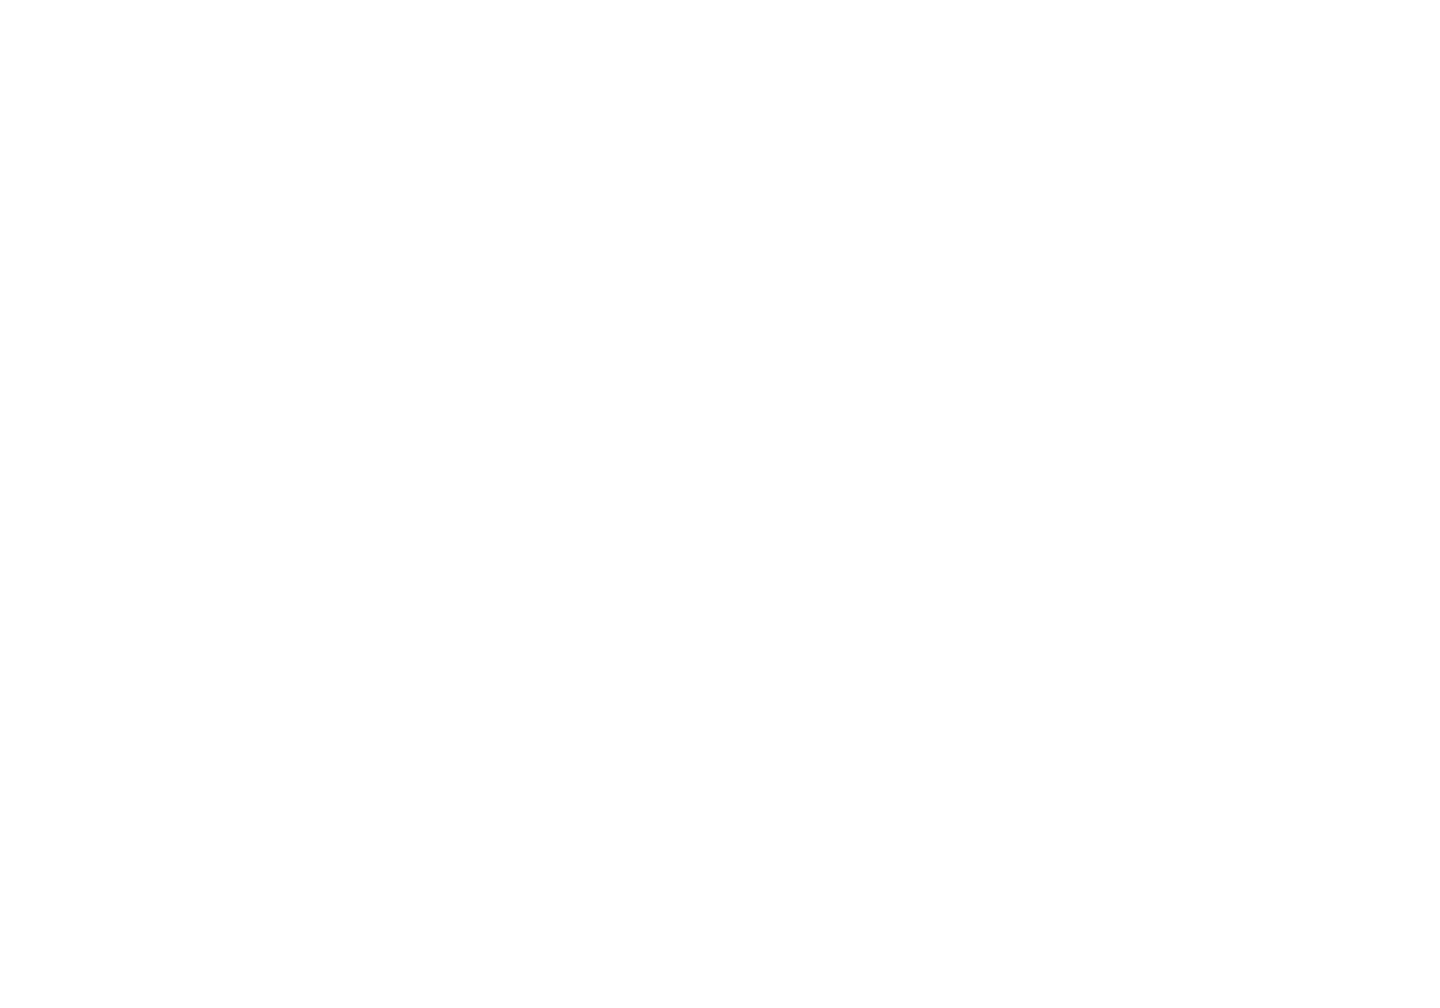

<IPython.core.display.Javascript object>


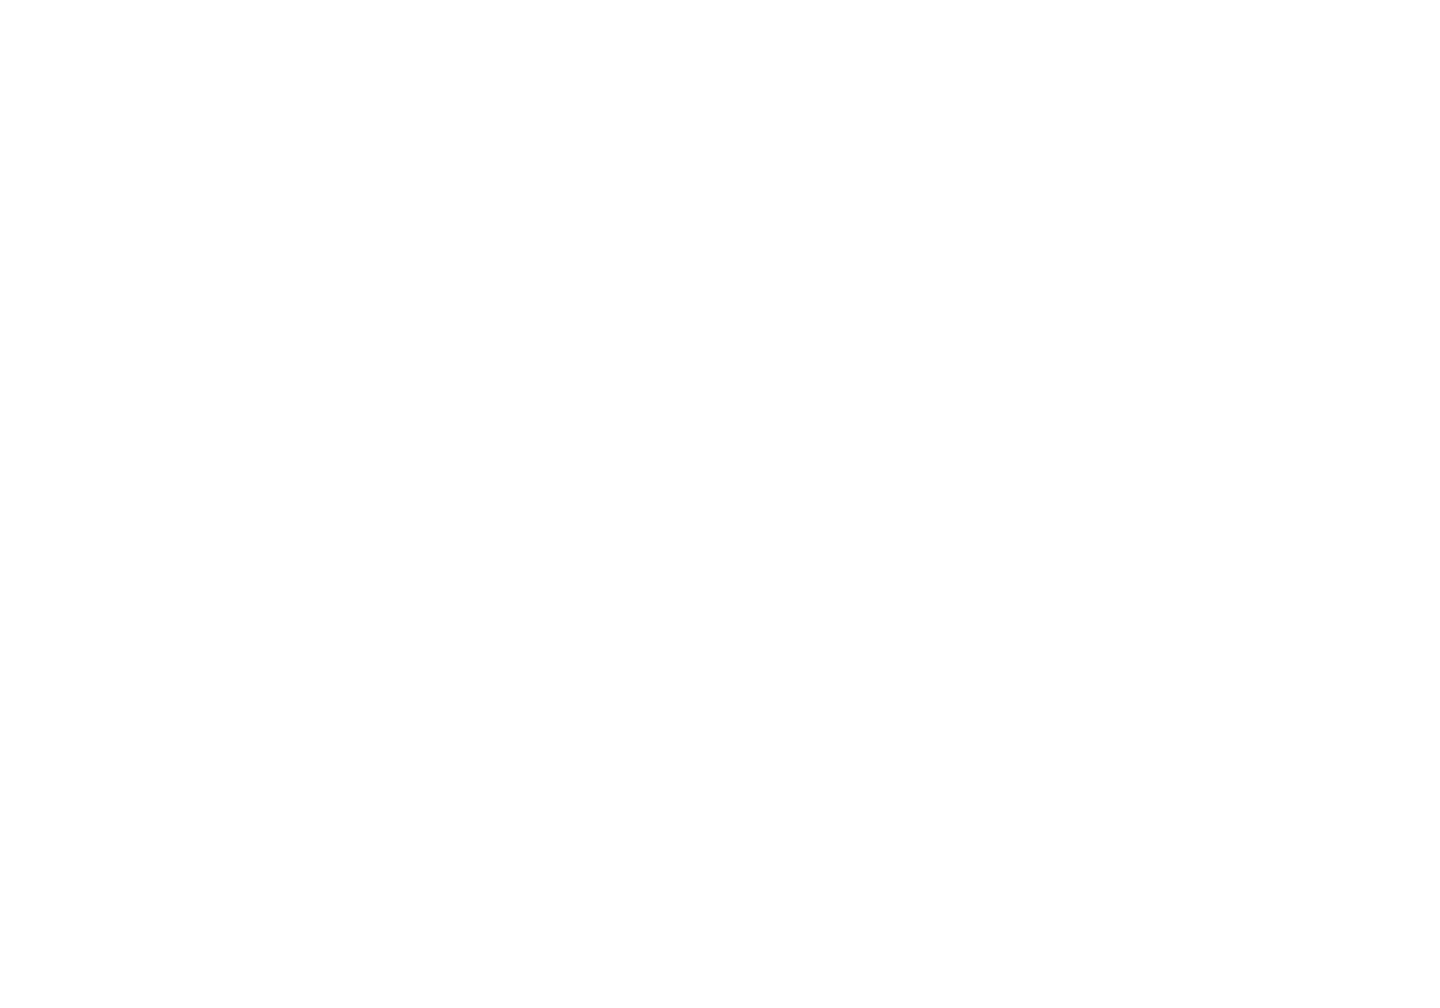

In [288]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')


In [289]:
scipy.optimize.fmin_bfgs(cut_f, cut_ctr0, fprime=cut_jacobian, callback=cut_callbackF)

   3-0.001828 0.000078 0.486555 0.741553-2.009340 1.874884 100.730046
   4-0.001963 0.000006 0.486480 0.741589-2.009334 1.874915 100.721388
   5-0.001018-0.000639 0.488698 0.760642-2.007083 1.886407 100.450262
   6-0.000376 0.000878 0.491113 0.789239-2.003727 1.903611 99.261398
   7 0.008068 0.008819 0.502189 1.149152-2.042269 1.947367 73.460846
   8 0.008137 0.008894 0.502301 1.152136-2.043519 1.948106 73.323478
   9 0.008745 0.009220 0.502300 1.173900-2.037233 1.942673 71.500081
  10 0.013097 0.008607 0.503278 1.290756-2.038168 1.919708 64.243206
  11 0.014147 0.008311 0.503270 1.319280-2.038941 1.912897 62.521095
  12 0.014564 0.006735 0.502306 1.367036-2.063650 1.897724 56.662678
  13 0.005258 0.000566 0.501115 1.283255-2.210347 1.913263 55.017124
  14 0.004068-0.000070 0.499946 1.264529-2.235262 1.914865 54.812797
         Current function value: 54.812797
         Iterations: 12
         Function evaluations: 159
         Gradient evaluations: 146


array([ 4.06782995e-03, -7.03995779e-05,  4.99945782e-01,  1.26452868e+00,
       -2.23526233e+00,  1.91486492e+00])

Differential Evolution

In [290]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]

In [270]:
%%time
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=1000, strategy='best1bin',\
                                                recombination=0.8, popsize=15, mutation=(1.0,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1 0.027405 0.062616 0.949929 2.245187 1.486381-3.798003 199.985784
   2 0.027405 0.062616 0.949929 2.245187 1.486381-3.798003 199.985784
   3 0.020074 0.060524 0.944732 0.111324 2.409556 4.598990 187.892619
   4-0.027269-0.006960 0.160080 1.039651 4.587899 5.244612 122.640836
   5-0.027269-0.006960 0.160080 1.039651 4.587899 5.244612 122.640836
   6-0.027269-0.006960 0.160080 1.039651 4.587899 5.244612 122.640836
   7-0.027269-0.006960 0.160080 1.039651 4.587899 5.244612 122.640836
   8 0.024148 0.008888 0.876979 3.299988 4.622597 4.174290 119.390241
   9-0.002734-0.020718 0.863370 2.566544-5.821652 4.112773 114.326100
  10-0.002734-0.012587 0.620392 0.494955 1.611580-2.653304 106.826664
  11-0.004714 0.013610 0.296885 1.380358-4.221410 0.100942 102.779379
  12-0.004714 0.013610 0.296885 1.380358-4.221410 0.100942 102.779379
  13-0.004714 0.013610 0.296885 1.380358-4.221410 0.100942 102.779379
  14-0.004714 0.013610 0.296885 1.380358-4.221410 0.100942 102.779379
  15-0.004714 0.0136

 121-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 122-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 123-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 124-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 125-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 126-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 127-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 128-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 129-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 130-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 131-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 132-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 133-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 134-0.002908 0.001083 0.381119 1.699970 1.951844 5.425679 87.758576
 135-0.002908 0.001083 0.381119 1.

In [ ]:
results.fun #30.26455552871073 

In [ ]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


In [ ]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [ ]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

In [ ]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [388]:
i = 1
def cut_callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(cut_f, bounds, callback=cut_callbackF, maxiter=1000, strategy='best1bin',\
                                                 recombination=0.7, popsize=15, mutation=(0.5,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   2-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   3-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   4-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   5-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   6-0.037382-0.006061 0.742930 4.300624 5.949646-3.066317 119.730539
   7 0.015357-0.002034 0.960508 1.082615-3.947953 1.477495 111.585206
   8 0.015357-0.002034 0.960508 1.082615-3.947953 1.477495 111.585206
   9 0.015357-0.002034 0.960508 1.082615-3.947953 1.477495 111.585206
  10-0.000727 0.005280 0.532778 1.489557-4.472991 0.611153 105.237134
  11-0.000727 0.005280 0.532778 1.489557-4.472991 0.611153 105.237134
  12 0.004953 0.005280 0.745856 4.232563 5.787091-2.117188 102.765209
  13-0.001305-0.002034 0.156912 3.878151 1.093753-0.972179 99.824929
  14-0.001305-0.002034 0.156912 3.878151 1.093753-0.972179 99.824929
  15-0.001305-0.002034

 120 0.015830 0.008536 0.911805 1.924883-0.952199 1.862204 81.703080
 121 0.015830 0.008536 0.911805 1.924883-0.952199 1.862204 81.703080
 122 0.015830 0.008536 0.911805 1.924883-0.952199 1.862204 81.703080
 123 0.015830 0.008536 0.911805 1.924883-0.952199 1.862204 81.703080
 124 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 125 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 126 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 127 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 128 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 129 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 130 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 131 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 132 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 133 0.010438 0.002933 0.934764 2.873999-0.672880 1.812562 80.440617
 134 0.010438 0.002933 0.934764 2.

 239 0.006217 0.006103 0.922151 2.589818-0.952737 1.822822 28.952490
 240 0.006217 0.006103 0.922151 2.589818-0.952737 1.822822 28.952490
 241 0.006217 0.006103 0.922151 2.589818-0.952737 1.822822 28.952490
 242 0.006217 0.006103 0.922151 2.589818-0.952737 1.822822 28.952490
 243 0.005941 0.005782 0.924554 2.590489-0.938607 1.823656 28.287884
 244 0.005941 0.005782 0.924554 2.590489-0.938607 1.823656 28.287884
 245 0.005941 0.005782 0.924554 2.590489-0.938607 1.823656 28.287884
 246 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 247 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 248 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 249 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 250 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 251 0.007038 0.005004 0.924568 2.576560-0.976621 1.824912 28.111017
 252 0.007120 0.007269 0.923620 2.586738-0.949168 1.823604 27.539032
 253 0.007120 0.007269 0.923620 2.

'    The differential evolution strategy should be one of:\n            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result\n            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result\n            ‘rand1exp’ - takes a long time but converges\n            ‘randtobest1exp’ - takes a long time but converges\n            ‘currenttobest1exp’ - takes a long time but converges\n            ‘best2exp’\n            ‘rand2exp’\n            ‘randtobest1bin’\n            ‘currenttobest1bin’\n            ‘best2bin’\n            ‘rand2bin’\n            ‘rand1bin’\n    The default is ‘best1bin’.\n'

In [ ]:
cut_dfe = results.x

In [ ]:
cut_evtClean, cut_ctr = sim.make_event(cut_dfe[0], cut_dfe[1], cut_dfe[2], cut_dfe[3], cut_dfe[4], cut_dfe[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [ ]:
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

In [ ]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])


In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')

In [544]:
i = 1
def callbackF(x, f, accept):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    i += 1

In [545]:
%%time
scipy.optimize.basinhopping(f,ctr0, callback=callbackF, niter=15, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "Powell"})

   1 0.004415-0.015374 0.721488 3.204851-2.936360 1.883255 30.231855
   2-0.000525-0.011618 0.730309 2.918246-2.921467 1.913337 17.241822
   3 0.000833 0.001103 1.123264 2.978791-3.037000 2.720093 98.780773
   4 203.714199-1.027011 815.284633 809.149734 820.931764 823.218391 nan
   5 418.472039 213.800202 1030.089903 1023.996341 1035.759228 1037.995579 nan
   6 633.262708 428.562848 1244.924962 1238.817316 1250.543869 1252.751018 nan
   7 848.041472 643.346661 1459.735817 1453.632496 1465.299885 1467.531326 nan
   8 1062.831346 858.176588 1674.557681 1668.401925 1680.112043 1682.373674 nan
   9 1277.617766 1072.926769 1889.347057 1883.196269 1894.935653 1897.165420 nan
  10 1492.465732 1287.714374 2104.121081 2097.959187 2109.754135 2111.993540 nan
  11 1707.284846 1502.501065 2318.917584 2312.749503 2324.507297 2326.830140 nan
  12 1922.114637 1717.281275 2533.670555 2527.568437 2539.292901 2541.623837 nan
  13 2136.871822 1932.044067 2748.511711 2742.380747 2754.079297 2756.455447 na

                        fun: 17.227109995291908
 lowest_optimization_result:    direc: array([[-6.23842603e-08,  1.97561715e-09,  3.49010564e-03,
         1.82841704e-02, -9.92798115e-03,  1.88365801e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.39113771e-07, -2.22953895e-09, -2.57317422e-07,
        -1.34806014e-06,  7.31929176e-07, -1.39627663e-07]])
     fun: 17.227109995291908
 message: 'Optimization terminated successfully.'
    nfev: 1105
     nit: 7
  status: 0
 success: True
       x: array([ 1.74647491e-03, -1.27633892e-02,  7.26365497e-0

In [546]:
j = 1
def cut_callbackF(x, f, accept):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    j += 1

In [547]:
%%time
scipy.optimize.basinhopping(cut_f,cut_ctr0, callback=cut_callbackF, niter=15, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "Powell"})

  16-0.000240 0.001442 1.105077 2.967173-3.051017 2.694880 98.438197
  16 0.010582-0.007856 0.736968 2.763867-2.851079 1.931727 17.206177
  16-0.004865-0.000966 0.879501 2.804145-2.852920 2.041769 78.251398
  16 0.009836-0.004753 0.745800 2.704702-2.832080 1.946035 21.648295
  16-0.000752-0.004275 1.224850 3.127129-3.031349 2.292149 96.066494
  16-0.001126-0.002411 2.479706 11.283627 6.012252 10.546346 99.507681
  16 0.002535-0.014146 0.728413 2.961466-2.960040 1.909141 18.135761
  16 0.006029-0.009804 0.734209 2.813555-2.910862 1.926337 14.599369
  16-0.005888-0.013925 0.721091 2.985330-3.027076 1.902666 20.948578
  16 0.001441 0.002779 0.455988 2.020742-2.895061 1.937444 53.468141
  16-0.001143 0.004131 0.982910 3.210512-2.931609 1.918803 82.061638
  16 0.015051-0.000460 0.755097 2.640778-2.748784 1.960102 32.248302
  16-0.002130 0.001782 0.982522 3.070310-3.095361 1.907833 81.168193
  16-0.000927-0.012371 0.726987 2.943948-2.975867 1.909715 17.772009
  16 0.005292-0.009342 0.737862 

                        fun: 14.599368754406232
 lowest_optimization_result:    direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.91557217e-03,  1.19048399e-03, -3.75506245e-03,
         6.43054032e-02, -1.16210953e-02, -8.79370245e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 5.67284854e-03,  4.12417701e-03, -1.23060592e-02,
        -6.59486908e-02,  1.50387834e-02, -3.18210831e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 7.70575981e-04, -1.94175492e-03, -1.51784141e-03,
         2.55986582e-02, -4.62197248e-03, -3.49505574e-03]])
     fun: 14.599368754406232
 message: 'Optimization terminated successfully.'
    nfev: 1764
     nit: 12
  status: 0
 success: True
       x: array([ 0.00602878, -0.0098045 ,  0.73420865,  2.81355